In [206]:
from __future__ import print_function

%matplotlib inline
from pyuvdata import UVData
from pyuvdata import UVCal
import os
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
from matplotlib import pyplot as plt
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, Angle
from astropy.time import Time
import matplotlib.animation as anm
from scipy.interpolate import interp1d

In [207]:
#### Default Input Parameters ####

#Path to FHD run:
path1 = "/lustre/aoc/projects/hera/dstorer/Projects/ssinsFHDRun/results/"
#JDs to execute on (assumes FHD results are organized into sub-directories by these names within path1)
days = ['2458098','2458099']
ant_nums = [51,70,52,53] #Antenna numbers to read in
plotName = 'testJupyterPlotting' #Base name for plots
outpath = "/lustre/aoc/projects/hera/dstorer/Projects/ssinsFHDRun/results/plots/" #Output directory for plots
frame_baseName = 'calMovieFrames' #Base name for movie frames
pol = 'Jxx' #Polarization to read in
freqrange=[120,185] #Frequency range (MHz) to read in and plot
visrange=[0,-1] #Range (indices) of observations array to read in and plot
colormap = 'plasma_r'
#Source to read calibration from (Either 'sav' for FHD .sav files, or 'fits' for UVCal cal.fits files:
#Note that for cal.fits files I assume they are stored in the calibration subdirectory with the same naming convention
source = 'sav'
#Option to write out a calfits file:
write_calfits = False



In [208]:
#### Setup paths and arrays ####

thedir = path1 + days[0]
vis = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
vis.sort()
obspath = path1 + days[0] + '/' + vis[10]
data_array = {}

In [209]:
#Get telescope location:
dat = UVData()
version = vis[10]
obsid = version[4:-20]
prefix = obspath + '/' + 'metadata' + '/' + obsid + '_'
files1 = [prefix + f for f in ['params.sav','settings.txt']]
prefix = obspath + '/' + 'vis_data' + '/' + obsid + '_'
files2 = [prefix + f for f in ['flags.sav','vis_XX.sav','vis_YY.sav','vis_model_XX.sav','vis_model_YY.sav']]
files = np.append(files1, files2)

dat.read_fhd(files)
loc = EarthLocation.from_geocentric(*dat.telescope_location, unit='m')

In [210]:
def get_zenithRA(time_array,telescope_location):
    zens = []
    for t in time_array:
        if t is None:
            zens.append(zens[-1] + (zens[-1]-zens[-2]))
        else:
            zen = SkyCoord(Angle(0, unit='deg'),Angle(90,unit='deg'),frame='altaz',obstime=t,location=telescope_location)
            zen = zen.transform_to('icrs')
            zen = zen.ra.degree
            zens.append(zen)
    return zens

In [211]:
def get_LSTs(time_array):
    lst_arr = []
    for i in range(len(time_array)):
        t = time_array[i]
        if t is not None:
            lst = t.sidereal_time('mean').hour
            lst_arr.append(lst)
        else:
            if i == 0:
                lst = 0
            else:
                lst = lst_arr[-1]+0.0139
            lst_arr.append(lst)
    return lst_arr

In [212]:
def read_data(data_array,path1,days,ant_nums,pol,freqrange,visrange,source,write_calfits):
    cal = UVCal()
    nants = len(ant_nums)
    for k in range(len(days)):
        day_array = []
        thedir = path1 + days[k]
        vis = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
        vis.sort()
        vis = vis[300:-150]
        for j in range(nants):
            nocal = 0
            i=0
            times = []
            for v in vis:
                data = True
                obs = v[4:-20]
                print('Reading data for antenna ' + str(ant_nums[j]) + ', Obs ' + str(obs))
                path = path1 + days[k] + '/' + v
                if os.path.exists(path + '/calibration/') is False:
                    print('!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!')
                    print('There is no calibration data for this observation. The gains for this observation will be entered as 0.')
                    nocal = nocal + 1
                    data = False
                    times.append(None)
                if source == 'sav':
                    if data == True:
                        obsfile = path + '/metadata/' + obs + '_obs.sav'
                        calfile = path + '/calibration/' + obs + '_cal.sav'
                        settingsfile = path + '/metadata/' + obs + '_settings.txt'
                        cal.read_fhd_cal(calfile,obsfile,settings_file=settingsfile)
                elif source == 'fits':
                    calfits = path + str(nums[i]) + '/calibration/' + obs + '_cal.fits'
                    cal.read_calfits(calfits)
                else:
                    print('####################### ERROR #####################')
                    print('The source must be set to either sav or fits')

                if write_calfits == True and data == True:
                    writepath = path + str(nums[i]) + '/calibration/' + obs + '_cal.fits'
                    cal.write_calfits(writepath, clobber=True)
                if i == 0 and data==True:
                    nobs = len(vis)
                    nfreqs = cal.Nfreqs
                    freq_array = cal.freq_array[0,:]
                    freq_array = np.transpose(freq_array)
                    freq_array = np.divide(freq_array,1000000)
                    minfreqind = np.argmax(freq_array>freqrange[0])
                    maxfreqind = np.argmin(freq_array<freqrange[1])
                    cal_array = np.empty((nfreqs,nobs))
                    mask_array = np.zeros((nfreqs,nobs))
                    if j == 0:
                        ## Get the LST start and end times for this obsid ##
                        time_array = cal.time_array
                        obstime_start = Time(time_array[0],format='jd',location=loc)
                        startTime = obstime_start.sidereal_time('mean').hour
                        JD = int(obstime_start.jd)
                if v == vis[-1] and j == 0:
                    time_array = cal.time_array
                    obstime_end = Time(time_array[-1],format='jd',location=loc)
                    endTime = obstime_end.sidereal_time('mean').hour
                if data is True:
                    gain = np.abs(cal.get_gains(ant_nums[j], pol))
                if data is False:
                    if i == 0:
                        continue
                    else:
                        gain = np.zeros(np.shape(gain))
                        cal_array[:,i] = gain[:,0]
                        mask_array[:,i] = np.ones(np.shape(gain))[:,0]
                        i = i + 1
                        continue
                cal_array[:,i] = gain[:,0]
                i = i + 1
                tArr = cal.time_array
                t = Time(tArr[0],format='jd',location=loc)
                times.append(t)
            cal_array = np.transpose(cal_array)
            mask_array = np.transpose(mask_array)
            cal_array = cal_array[:,minfreqind:maxfreqind]
            mask_array = mask_array[:,minfreqind:maxfreqind]
            ## Getting max and min values ##
            calsort = np.sort(cal_array)
            maxind = int(len(calsort[0])/15)
            maxuse = calsort[:,-maxind]
            maxuse = np.max(maxuse)
            if maxuse >=5:
                    maxind = int(len(calsort[0])/12)
                    maxuse = calsort[:,-maxind]
                    maxuse = np.max(maxuse)
                    print('!!!!!!!!!!!!!!!!!!! Had to adjust max used value !!!!!!!!!!!!!!!!!!!')
            maxval = np.max(calsort[:,-1])
            print('Maximum gain value is: ' + str(maxval))
            print('Maximum gain value used is: ' + str(maxuse))
            freq_array = freq_array[minfreqind:maxfreqind]
            mx = np.ma.masked_array(cal_array, mask=mask_array)
            lst_array = get_LSTs(times)
            zenith_RAs = get_zenithRA(times,loc)
            res = {
                    "ant_num": ant_nums[j],
                    "obsid": obs,
                    "cal_array": cal_array,
                    "time_array": times,
                    "freq_array": freq_array,
                    "masked_data": mx,
                    "zenith_RA_array": zenith_RAs,
                    "lst_array": lst_array,
                    "pol": pol
                }
            day_array.append(res)
            print('###############################################################')
            print('Out of ' + str(len(vis)) + ' observations, ' + str(nocal) + ' did not contain calibration solutions')
            print('###############################################################')
        data_array[days[k]] = day_array
    return data_array

In [307]:
cal = UVCal()
nants = len(ant_nums)
for k in range(len(days)):
    day_array = {}
    thedir = path1 + days[k]
    vis = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
    vis.sort()
    vis = vis[visrange[0]:visrange[1]]
    for j in range(nants):
        nocal = 0
        i=0
        times = []
        for v in vis:
            data = True
            obs = v[4:-20]
            print('Reading data for antenna ' + str(ant_nums[j]) + ', Obs ' + str(obs))
            path = path1 + days[k] + '/' + v
            if os.path.exists(path + '/calibration/') is False:
                print('!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!')
                print('There is no calibration data for this observation. The gains for this observation will be entered as 0.')
                nocal = nocal + 1
                data = False
                times.append(None)
            if source == 'sav':
                if data == True:
                    obsfile = path + '/metadata/' + obs + '_obs.sav'
                    calfile = path + '/calibration/' + obs + '_cal.sav'
                    settingsfile = path + '/metadata/' + obs + '_settings.txt'
                    cal.read_fhd_cal(calfile,obsfile,settings_file=settingsfile)
            elif source == 'fits':
                calfits = path + str(nums[i]) + '/calibration/' + obs + '_cal.fits'
                cal.read_calfits(calfits)
            else:
                print('####################### ERROR #####################')
                print('The source must be set to either sav or fits')

            if write_calfits == True and data == True:
                outpath = path + str(nums[i]) + '/calibration/' + obs + '_cal.fits'
                cal.write_calfits(outpath, clobber=True)
            if i == 0 and data==True:
                nobs = len(vis)
                nfreqs = cal.Nfreqs
                freq_array = cal.freq_array[0,:]
                freq_array = np.transpose(freq_array)
                freq_array = np.divide(freq_array,1000000)
                minfreqind = np.argmax(freq_array>freqrange[0])
                maxfreqind = np.argmin(freq_array<freqrange[1])
                cal_array = np.empty((nfreqs,nobs))
                mask_array = np.zeros((nfreqs,nobs))
                if j == 0:
                    ## Get the LST start and end times for this obsid ##
                    time_array = cal.time_array
                    obstime_start = Time(time_array[0],format='jd',location=loc)
                    startTime = obstime_start.sidereal_time('mean').hour
                    JD = int(obstime_start.jd)
            if v == vis[-1] and j == 0:
                time_array = cal.time_array
                obstime_end = Time(time_array[-1],format='jd',location=loc)
                endTime = obstime_end.sidereal_time('mean').hour
            if data is True:
                gain = np.abs(cal.get_gains(ant_nums[j], pol))
            if data is False:
                if i == 0:
                    continue
                else:
                    gain = np.zeros(np.shape(gain))
                    cal_array[:,i] = gain[:,0]
                    mask_array[:,i] = np.ones(np.shape(gain))[:,0]
                    i = i + 1
                    continue
            cal_array[:,i] = gain[:,0]
            i = i + 1
            tArr = cal.time_array
            t = Time(tArr[0],format='jd',location=loc)
            times.append(t)
        cal_array = np.transpose(cal_array)
        mask_array = np.transpose(mask_array)
        cal_array = cal_array[:,minfreqind:maxfreqind]
        mask_array = mask_array[:,minfreqind:maxfreqind]
        ## Getting max and min values ##
        calsort = np.sort(cal_array)
        maxind = int(len(calsort[0])/15)
        maxuse = calsort[:,-maxind]
        maxuse = np.max(maxuse)
        if maxuse >=5:
                maxind = int(len(calsort[0])/12)
                maxuse = calsort[:,-maxind]
                maxuse = np.max(maxuse)
                print('!!!!!!!!!!!!!!!!!!! Had to adjust max used value !!!!!!!!!!!!!!!!!!!')
        maxval = np.max(calsort[:,-1])
        print('Maximum gain value is: ' + str(maxval))
        print('Maximum gain value used is: ' + str(maxuse))
        freq_array = freq_array[minfreqind:maxfreqind]
        mx = np.ma.masked_array(cal_array, mask=mask_array)
        lst_array = get_LSTs(times)
        zenith_RAs = get_zenithRA(times,loc)
        res = {
                "ant_num": ant_nums[j],
                "obsid": obs,
                "cal_array": cal_array,
                "time_array": times,
                "freq_array": freq_array,
                "masked_data": mx,
                "zenith_RA_array": zenith_RAs,
                "lst_array": lst_array,
                "pol": pol
            }
        antenna = ant_nums[j]
        day_array[antenna] = res
        print('###############################################################')
        print('Out of ' + str(len(vis)) + ' observations, ' + str(nocal) + ' did not contain calibration solutions')
        print('###############################################################')
    data_array[days[k]] = day_array

Reading data for antenna 51, Obs 2458098.125581585
Reading data for antenna 51, Obs 2458098.1262029633
Reading data for antenna 51, Obs 2458098.1268243417
Reading data for antenna 51, Obs 2458098.12744572
Reading data for antenna 51, Obs 2458098.1280670986
Reading data for antenna 51, Obs 2458098.128688477
Reading data for antenna 51, Obs 2458098.1293098554
Reading data for antenna 51, Obs 2458098.129931234
Reading data for antenna 51, Obs 2458098.1305526122
Reading data for antenna 51, Obs 2458098.1311739907
Reading data for antenna 51, Obs 2458098.131795369
Reading data for antenna 51, Obs 2458098.1324167475
Reading data for antenna 51, Obs 2458098.133038126
Reading data for antenna 51, Obs 2458098.1336595044
Reading data for antenna 51, Obs 2458098.134280883
Reading data for antenna 51, Obs 2458098.134902261
Reading data for antenna 51, Obs 2458098.1355236396
Reading data for antenna 51, Obs 2458098.136145018
Reading data for antenna 51, Obs 2458098.1367663965
Reading data for anten

Reading data for antenna 51, Obs 2458098.217545584
Reading data for antenna 51, Obs 2458098.2181669623
Reading data for antenna 51, Obs 2458098.2187883407
Reading data for antenna 51, Obs 2458098.219409719
Reading data for antenna 51, Obs 2458098.2200310975
Reading data for antenna 51, Obs 2458098.220652474
Reading data for antenna 51, Obs 2458098.2212738525
Reading data for antenna 51, Obs 2458098.221895231
Reading data for antenna 51, Obs 2458098.2225166094
Reading data for antenna 51, Obs 2458098.223137988
Reading data for antenna 51, Obs 2458098.223759366
Reading data for antenna 51, Obs 2458098.2243807446
Reading data for antenna 51, Obs 2458098.225002123
Reading data for antenna 51, Obs 2458098.2256235015
Reading data for antenna 51, Obs 2458098.22624488
Reading data for antenna 51, Obs 2458098.2268662583
Reading data for antenna 51, Obs 2458098.2274876367
Reading data for antenna 51, Obs 2458098.228109015
Reading data for antenna 51, Obs 2458098.2287303936
Reading data for anten

Reading data for antenna 51, Obs 2458098.3076454476
Reading data for antenna 51, Obs 2458098.308266826
Reading data for antenna 51, Obs 2458098.3088882044
Reading data for antenna 51, Obs 2458098.309509583
Reading data for antenna 51, Obs 2458098.3101309612
Reading data for antenna 51, Obs 2458098.3107523397
Reading data for antenna 51, Obs 2458098.311373718
Reading data for antenna 51, Obs 2458098.3119950965
Reading data for antenna 51, Obs 2458098.312616475
Reading data for antenna 51, Obs 2458098.3132378533
Reading data for antenna 51, Obs 2458098.313859232
Reading data for antenna 51, Obs 2458098.31448061
Reading data for antenna 51, Obs 2458098.3151019886
Reading data for antenna 51, Obs 2458098.315723367
Reading data for antenna 51, Obs 2458098.3163447455
Reading data for antenna 51, Obs 2458098.316966124
Reading data for antenna 51, Obs 2458098.3175875023
Reading data for antenna 51, Obs 2458098.3182088807
Reading data for antenna 51, Obs 2458098.318830259
Reading data for anten

Reading data for antenna 51, Obs 2458098.372268796
Reading data for antenna 51, Obs 2458098.3728901744
Reading data for antenna 51, Obs 2458098.373511553
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.374132931
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.3747543097
Reading data for antenna 51, Obs 2458098.375375688
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.3759970665
Reading data for antenna 51, Obs 2458098.376618445
Reading data for antenna 51, Obs 2458098.3772398233
Reading data for antenna 51, Obs 2458098.3778612018
Reading data for antenna 51, Obs

Reading data for antenna 51, Obs 2458098.456776254
Reading data for antenna 51, Obs 2458098.4573976323
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.4580190107
Reading data for antenna 51, Obs 2458098.458640389
Reading data for antenna 51, Obs 2458098.4592617676
Reading data for antenna 51, Obs 2458098.459883146
Reading data for antenna 51, Obs 2458098.4605045244
Reading data for antenna 51, Obs 2458098.461125903
Reading data for antenna 51, Obs 2458098.4617472813
Reading data for antenna 51, Obs 2458098.4623686597
Reading data for antenna 51, Obs 2458098.462990038
Reading data for antenna 51, Obs 2458098.4636114165
Reading data for antenna 51, Obs 2458098.464232795
Reading data for antenna 51, Obs 2458098.4648541734
Reading data for antenna 51, Obs 2458098.465475552
Reading data for antenna 51, Obs 2458098.46609693
Reading data for antenna 5

Reading data for antenna 51, Obs 2458098.554954037
Reading data for antenna 51, Obs 2458098.5555754155
Reading data for antenna 51, Obs 2458098.556196794
Reading data for antenna 51, Obs 2458098.5568181723
Reading data for antenna 51, Obs 2458098.5574395508
Reading data for antenna 51, Obs 2458098.558060929
Reading data for antenna 51, Obs 2458098.5586823076
Reading data for antenna 51, Obs 2458098.559303686
Reading data for antenna 51, Obs 2458098.5599250644
Reading data for antenna 51, Obs 2458098.560546443
Reading data for antenna 51, Obs 2458098.5611678213
Reading data for antenna 51, Obs 2458098.5617891997
Reading data for antenna 51, Obs 2458098.562410578
Reading data for antenna 51, Obs 2458098.5630319566
Reading data for antenna 51, Obs 2458098.563653335
Reading data for antenna 51, Obs 2458098.5642747134
Reading data for antenna 51, Obs 2458098.564896092
Reading data for antenna 51, Obs 2458098.5655174702
Reading data for antenna 51, Obs 2458098.5661388487
Reading data for ant

Reading data for antenna 51, Obs 2458098.645053901
Reading data for antenna 51, Obs 2458098.645675279
Reading data for antenna 51, Obs 2458098.6462966576
Reading data for antenna 51, Obs 2458098.646918036
Reading data for antenna 51, Obs 2458098.6475394145
Reading data for antenna 51, Obs 2458098.648160793
Reading data for antenna 51, Obs 2458098.6487821713
Reading data for antenna 51, Obs 2458098.6494035497
Reading data for antenna 51, Obs 2458098.650024928
Reading data for antenna 51, Obs 2458098.6506463066
Reading data for antenna 51, Obs 2458098.651267685
Reading data for antenna 51, Obs 2458098.6518890634
Reading data for antenna 51, Obs 2458098.652510442
Reading data for antenna 51, Obs 2458098.6531318203
Reading data for antenna 51, Obs 2458098.6537531987
Reading data for antenna 51, Obs 2458098.654374577
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 

Reading data for antenna 70, Obs 2458098.19144769
Reading data for antenna 70, Obs 2458098.1920690686
Reading data for antenna 70, Obs 2458098.192690447
Reading data for antenna 70, Obs 2458098.1933118254
Reading data for antenna 70, Obs 2458098.193933204
Reading data for antenna 70, Obs 2458098.1945545822
Reading data for antenna 70, Obs 2458098.1951759607
Reading data for antenna 70, Obs 2458098.195797339
Reading data for antenna 70, Obs 2458098.1964187175
Reading data for antenna 70, Obs 2458098.197040096
Reading data for antenna 70, Obs 2458098.1976614743
Reading data for antenna 70, Obs 2458098.198282853
Reading data for antenna 70, Obs 2458098.198904231
Reading data for antenna 70, Obs 2458098.1995256096
Reading data for antenna 70, Obs 2458098.200146988
Reading data for antenna 70, Obs 2458098.2007683665
Reading data for antenna 70, Obs 2458098.201389745
Reading data for antenna 70, Obs 2458098.2020111233
Reading data for antenna 70, Obs 2458098.2026325017
Reading data for anten

Reading data for antenna 70, Obs 2458098.2796834204
Reading data for antenna 70, Obs 2458098.280304799
Reading data for antenna 70, Obs 2458098.2809261773
Reading data for antenna 70, Obs 2458098.281547554
Reading data for antenna 70, Obs 2458098.2821689323
Reading data for antenna 70, Obs 2458098.2827903107
Reading data for antenna 70, Obs 2458098.283411689
Reading data for antenna 70, Obs 2458098.2840330675
Reading data for antenna 70, Obs 2458098.284654446
Reading data for antenna 70, Obs 2458098.2852758244
Reading data for antenna 70, Obs 2458098.285897203
Reading data for antenna 70, Obs 2458098.286518581
Reading data for antenna 70, Obs 2458098.2871399596
Reading data for antenna 70, Obs 2458098.287761338
Reading data for antenna 70, Obs 2458098.2883827165
Reading data for antenna 70, Obs 2458098.289004095
Reading data for antenna 70, Obs 2458098.2896254733
Reading data for antenna 70, Obs 2458098.2902468517
Reading data for antenna 70, Obs 2458098.29086823
Reading data for anten

Reading data for antenna 70, Obs 2458098.372268796
Reading data for antenna 70, Obs 2458098.3728901744
Reading data for antenna 70, Obs 2458098.373511553
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458098.374132931
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458098.3747543097
Reading data for antenna 70, Obs 2458098.375375688
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458098.3759970665
Reading data for antenna 70, Obs 2458098.376618445
Reading data for antenna 70, Obs 2458098.3772398233
Reading data for antenna 70, Obs 2458098.3778612018
Reading data for antenna 70, Obs

Reading data for antenna 70, Obs 2458098.456776254
Reading data for antenna 70, Obs 2458098.4573976323
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458098.4580190107
Reading data for antenna 70, Obs 2458098.458640389
Reading data for antenna 70, Obs 2458098.4592617676
Reading data for antenna 70, Obs 2458098.459883146
Reading data for antenna 70, Obs 2458098.4605045244
Reading data for antenna 70, Obs 2458098.461125903
Reading data for antenna 70, Obs 2458098.4617472813
Reading data for antenna 70, Obs 2458098.4623686597
Reading data for antenna 70, Obs 2458098.462990038
Reading data for antenna 70, Obs 2458098.4636114165
Reading data for antenna 70, Obs 2458098.464232795
Reading data for antenna 70, Obs 2458098.4648541734
Reading data for antenna 70, Obs 2458098.465475552
Reading data for antenna 70, Obs 2458098.46609693
Reading data for antenna 7

Reading data for antenna 70, Obs 2458098.5555754155
Reading data for antenna 70, Obs 2458098.556196794
Reading data for antenna 70, Obs 2458098.5568181723
Reading data for antenna 70, Obs 2458098.5574395508
Reading data for antenna 70, Obs 2458098.558060929
Reading data for antenna 70, Obs 2458098.5586823076
Reading data for antenna 70, Obs 2458098.559303686
Reading data for antenna 70, Obs 2458098.5599250644
Reading data for antenna 70, Obs 2458098.560546443
Reading data for antenna 70, Obs 2458098.5611678213
Reading data for antenna 70, Obs 2458098.5617891997
Reading data for antenna 70, Obs 2458098.562410578
Reading data for antenna 70, Obs 2458098.5630319566
Reading data for antenna 70, Obs 2458098.563653335
Reading data for antenna 70, Obs 2458098.5642747134
Reading data for antenna 70, Obs 2458098.564896092
Reading data for antenna 70, Obs 2458098.5655174702
Reading data for antenna 70, Obs 2458098.5661388487
Reading data for antenna 70, Obs 2458098.566760227
Reading data for ant

Reading data for antenna 70, Obs 2458098.645675279
Reading data for antenna 70, Obs 2458098.6462966576
Reading data for antenna 70, Obs 2458098.646918036
Reading data for antenna 70, Obs 2458098.6475394145
Reading data for antenna 70, Obs 2458098.648160793
Reading data for antenna 70, Obs 2458098.6487821713
Reading data for antenna 70, Obs 2458098.6494035497
Reading data for antenna 70, Obs 2458098.650024928
Reading data for antenna 70, Obs 2458098.6506463066
Reading data for antenna 70, Obs 2458098.651267685
Reading data for antenna 70, Obs 2458098.6518890634
Reading data for antenna 70, Obs 2458098.652510442
Reading data for antenna 70, Obs 2458098.6531318203
Reading data for antenna 70, Obs 2458098.6537531987
Reading data for antenna 70, Obs 2458098.654374577
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458098.6549959555
Reading data for antenna

Reading data for antenna 52, Obs 2458098.1908263117
Reading data for antenna 52, Obs 2458098.19144769
Reading data for antenna 52, Obs 2458098.1920690686
Reading data for antenna 52, Obs 2458098.192690447
Reading data for antenna 52, Obs 2458098.1933118254
Reading data for antenna 52, Obs 2458098.193933204
Reading data for antenna 52, Obs 2458098.1945545822
Reading data for antenna 52, Obs 2458098.1951759607
Reading data for antenna 52, Obs 2458098.195797339
Reading data for antenna 52, Obs 2458098.1964187175
Reading data for antenna 52, Obs 2458098.197040096
Reading data for antenna 52, Obs 2458098.1976614743
Reading data for antenna 52, Obs 2458098.198282853
Reading data for antenna 52, Obs 2458098.198904231
Reading data for antenna 52, Obs 2458098.1995256096
Reading data for antenna 52, Obs 2458098.200146988
Reading data for antenna 52, Obs 2458098.2007683665
Reading data for antenna 52, Obs 2458098.201389745
Reading data for antenna 52, Obs 2458098.2020111233
Reading data for anten

Reading data for antenna 52, Obs 2458098.279062042
Reading data for antenna 52, Obs 2458098.2796834204
Reading data for antenna 52, Obs 2458098.280304799
Reading data for antenna 52, Obs 2458098.2809261773
Reading data for antenna 52, Obs 2458098.281547554
Reading data for antenna 52, Obs 2458098.2821689323
Reading data for antenna 52, Obs 2458098.2827903107
Reading data for antenna 52, Obs 2458098.283411689
Reading data for antenna 52, Obs 2458098.2840330675
Reading data for antenna 52, Obs 2458098.284654446
Reading data for antenna 52, Obs 2458098.2852758244
Reading data for antenna 52, Obs 2458098.285897203
Reading data for antenna 52, Obs 2458098.286518581
Reading data for antenna 52, Obs 2458098.2871399596
Reading data for antenna 52, Obs 2458098.287761338
Reading data for antenna 52, Obs 2458098.2883827165
Reading data for antenna 52, Obs 2458098.289004095
Reading data for antenna 52, Obs 2458098.2896254733
Reading data for antenna 52, Obs 2458098.2902468517
Reading data for ante

Reading data for antenna 52, Obs 2458098.372268796
Reading data for antenna 52, Obs 2458098.3728901744
Reading data for antenna 52, Obs 2458098.373511553
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458098.374132931
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458098.3747543097
Reading data for antenna 52, Obs 2458098.375375688
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458098.3759970665
Reading data for antenna 52, Obs 2458098.376618445
Reading data for antenna 52, Obs 2458098.3772398233
Reading data for antenna 52, Obs 2458098.3778612018
Reading data for antenna 52, Obs

Reading data for antenna 52, Obs 2458098.456776254
Reading data for antenna 52, Obs 2458098.4573976323
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458098.4580190107
Reading data for antenna 52, Obs 2458098.458640389
Reading data for antenna 52, Obs 2458098.4592617676
Reading data for antenna 52, Obs 2458098.459883146
Reading data for antenna 52, Obs 2458098.4605045244
Reading data for antenna 52, Obs 2458098.461125903
Reading data for antenna 52, Obs 2458098.4617472813
Reading data for antenna 52, Obs 2458098.4623686597
Reading data for antenna 52, Obs 2458098.462990038
Reading data for antenna 52, Obs 2458098.4636114165
Reading data for antenna 52, Obs 2458098.464232795
Reading data for antenna 52, Obs 2458098.4648541734
Reading data for antenna 52, Obs 2458098.465475552
Reading data for antenna 52, Obs 2458098.46609693
Reading data for antenna 5

Reading data for antenna 52, Obs 2458098.5555754155
Reading data for antenna 52, Obs 2458098.556196794
Reading data for antenna 52, Obs 2458098.5568181723
Reading data for antenna 52, Obs 2458098.5574395508
Reading data for antenna 52, Obs 2458098.558060929
Reading data for antenna 52, Obs 2458098.5586823076
Reading data for antenna 52, Obs 2458098.559303686
Reading data for antenna 52, Obs 2458098.5599250644
Reading data for antenna 52, Obs 2458098.560546443
Reading data for antenna 52, Obs 2458098.5611678213
Reading data for antenna 52, Obs 2458098.5617891997
Reading data for antenna 52, Obs 2458098.562410578
Reading data for antenna 52, Obs 2458098.5630319566
Reading data for antenna 52, Obs 2458098.563653335
Reading data for antenna 52, Obs 2458098.5642747134
Reading data for antenna 52, Obs 2458098.564896092
Reading data for antenna 52, Obs 2458098.5655174702
Reading data for antenna 52, Obs 2458098.5661388487
Reading data for antenna 52, Obs 2458098.566760227
Reading data for ant

Reading data for antenna 52, Obs 2458098.645675279
Reading data for antenna 52, Obs 2458098.6462966576
Reading data for antenna 52, Obs 2458098.646918036
Reading data for antenna 52, Obs 2458098.6475394145
Reading data for antenna 52, Obs 2458098.648160793
Reading data for antenna 52, Obs 2458098.6487821713
Reading data for antenna 52, Obs 2458098.6494035497
Reading data for antenna 52, Obs 2458098.650024928
Reading data for antenna 52, Obs 2458098.6506463066
Reading data for antenna 52, Obs 2458098.651267685
Reading data for antenna 52, Obs 2458098.6518890634
Reading data for antenna 52, Obs 2458098.652510442
Reading data for antenna 52, Obs 2458098.6531318203
Reading data for antenna 52, Obs 2458098.6537531987
Reading data for antenna 52, Obs 2458098.654374577
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458098.6549959555
Reading data for antenna

Reading data for antenna 53, Obs 2458098.1908263117
Reading data for antenna 53, Obs 2458098.19144769
Reading data for antenna 53, Obs 2458098.1920690686
Reading data for antenna 53, Obs 2458098.192690447
Reading data for antenna 53, Obs 2458098.1933118254
Reading data for antenna 53, Obs 2458098.193933204
Reading data for antenna 53, Obs 2458098.1945545822
Reading data for antenna 53, Obs 2458098.1951759607
Reading data for antenna 53, Obs 2458098.195797339
Reading data for antenna 53, Obs 2458098.1964187175
Reading data for antenna 53, Obs 2458098.197040096
Reading data for antenna 53, Obs 2458098.1976614743
Reading data for antenna 53, Obs 2458098.198282853
Reading data for antenna 53, Obs 2458098.198904231
Reading data for antenna 53, Obs 2458098.1995256096
Reading data for antenna 53, Obs 2458098.200146988
Reading data for antenna 53, Obs 2458098.2007683665
Reading data for antenna 53, Obs 2458098.201389745
Reading data for antenna 53, Obs 2458098.2020111233
Reading data for anten

Reading data for antenna 53, Obs 2458098.279062042
Reading data for antenna 53, Obs 2458098.2796834204
Reading data for antenna 53, Obs 2458098.280304799
Reading data for antenna 53, Obs 2458098.2809261773
Reading data for antenna 53, Obs 2458098.281547554
Reading data for antenna 53, Obs 2458098.2821689323
Reading data for antenna 53, Obs 2458098.2827903107
Reading data for antenna 53, Obs 2458098.283411689
Reading data for antenna 53, Obs 2458098.2840330675
Reading data for antenna 53, Obs 2458098.284654446
Reading data for antenna 53, Obs 2458098.2852758244
Reading data for antenna 53, Obs 2458098.285897203
Reading data for antenna 53, Obs 2458098.286518581
Reading data for antenna 53, Obs 2458098.2871399596
Reading data for antenna 53, Obs 2458098.287761338
Reading data for antenna 53, Obs 2458098.2883827165
Reading data for antenna 53, Obs 2458098.289004095
Reading data for antenna 53, Obs 2458098.2896254733
Reading data for antenna 53, Obs 2458098.2902468517
Reading data for ante

Reading data for antenna 53, Obs 2458098.372268796
Reading data for antenna 53, Obs 2458098.3728901744
Reading data for antenna 53, Obs 2458098.373511553
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458098.374132931
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458098.3747543097
Reading data for antenna 53, Obs 2458098.375375688
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458098.3759970665
Reading data for antenna 53, Obs 2458098.376618445
Reading data for antenna 53, Obs 2458098.3772398233
Reading data for antenna 53, Obs 2458098.3778612018
Reading data for antenna 53, Obs

Reading data for antenna 53, Obs 2458098.456776254
Reading data for antenna 53, Obs 2458098.4573976323
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458098.4580190107
Reading data for antenna 53, Obs 2458098.458640389
Reading data for antenna 53, Obs 2458098.4592617676
Reading data for antenna 53, Obs 2458098.459883146
Reading data for antenna 53, Obs 2458098.4605045244
Reading data for antenna 53, Obs 2458098.461125903
Reading data for antenna 53, Obs 2458098.4617472813
Reading data for antenna 53, Obs 2458098.4623686597
Reading data for antenna 53, Obs 2458098.462990038
Reading data for antenna 53, Obs 2458098.4636114165
Reading data for antenna 53, Obs 2458098.464232795
Reading data for antenna 53, Obs 2458098.4648541734
Reading data for antenna 53, Obs 2458098.465475552
Reading data for antenna 53, Obs 2458098.46609693
Reading data for antenna 5

Reading data for antenna 53, Obs 2458098.5555754155
Reading data for antenna 53, Obs 2458098.556196794
Reading data for antenna 53, Obs 2458098.5568181723
Reading data for antenna 53, Obs 2458098.5574395508
Reading data for antenna 53, Obs 2458098.558060929
Reading data for antenna 53, Obs 2458098.5586823076
Reading data for antenna 53, Obs 2458098.559303686
Reading data for antenna 53, Obs 2458098.5599250644
Reading data for antenna 53, Obs 2458098.560546443
Reading data for antenna 53, Obs 2458098.5611678213
Reading data for antenna 53, Obs 2458098.5617891997
Reading data for antenna 53, Obs 2458098.562410578
Reading data for antenna 53, Obs 2458098.5630319566
Reading data for antenna 53, Obs 2458098.563653335
Reading data for antenna 53, Obs 2458098.5642747134
Reading data for antenna 53, Obs 2458098.564896092
Reading data for antenna 53, Obs 2458098.5655174702
Reading data for antenna 53, Obs 2458098.5661388487
Reading data for antenna 53, Obs 2458098.566760227
Reading data for ant

Reading data for antenna 53, Obs 2458098.645675279
Reading data for antenna 53, Obs 2458098.6462966576
Reading data for antenna 53, Obs 2458098.646918036
Reading data for antenna 53, Obs 2458098.6475394145
Reading data for antenna 53, Obs 2458098.648160793
Reading data for antenna 53, Obs 2458098.6487821713
Reading data for antenna 53, Obs 2458098.6494035497
Reading data for antenna 53, Obs 2458098.650024928
Reading data for antenna 53, Obs 2458098.6506463066
Reading data for antenna 53, Obs 2458098.651267685
Reading data for antenna 53, Obs 2458098.6518890634
Reading data for antenna 53, Obs 2458098.652510442
Reading data for antenna 53, Obs 2458098.6531318203
Reading data for antenna 53, Obs 2458098.6537531987
Reading data for antenna 53, Obs 2458098.654374577
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458098.6549959555
Reading data for antenna

Reading data for antenna 51, Obs 2458099.1833676994
Reading data for antenna 51, Obs 2458099.183989078
Reading data for antenna 51, Obs 2458099.184610456
Reading data for antenna 51, Obs 2458099.1852318347
Reading data for antenna 51, Obs 2458099.185853213
Reading data for antenna 51, Obs 2458099.1864745915
Reading data for antenna 51, Obs 2458099.18709597
Reading data for antenna 51, Obs 2458099.1877173483
Reading data for antenna 51, Obs 2458099.1883387268
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458099.188960105
Reading data for antenna 51, Obs 2458099.1895814836
Reading data for antenna 51, Obs 2458099.190202862
Reading data for antenna 51, Obs 2458099.1908242404
Reading data for antenna 51, Obs 2458099.191445619
Reading data for antenna 51, Obs 2458099.1920669936
Reading data for antenna 51, Obs 2458099.192688372
!!!!!!!!!!!!!!!!!!!!WARNIN

Reading data for antenna 51, Obs 2458099.234942103
Reading data for antenna 51, Obs 2458099.235563481
Reading data for antenna 51, Obs 2458099.2361848596
Reading data for antenna 51, Obs 2458099.236806238
Reading data for antenna 51, Obs 2458099.2374276165
Reading data for antenna 51, Obs 2458099.238048995
Reading data for antenna 51, Obs 2458099.2386703733
Reading data for antenna 51, Obs 2458099.2392917518
Reading data for antenna 51, Obs 2458099.23991313
Reading data for antenna 51, Obs 2458099.2405345086
Reading data for antenna 51, Obs 2458099.241155887
Reading data for antenna 51, Obs 2458099.2417772654
Reading data for antenna 51, Obs 2458099.2423986434
Reading data for antenna 51, Obs 2458099.2430200214
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458099.2436414
Reading data for antenna 51, Obs 2458099.244262778
Reading data for antenna 51,

Reading data for antenna 51, Obs 2458099.3269061
Reading data for antenna 51, Obs 2458099.3275274783
Reading data for antenna 51, Obs 2458099.3281488568
Reading data for antenna 51, Obs 2458099.328770235
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458099.3293916136
Reading data for antenna 51, Obs 2458099.330012992
Reading data for antenna 51, Obs 2458099.3306343704
Reading data for antenna 51, Obs 2458099.331255749
Reading data for antenna 51, Obs 2458099.3318771273
Reading data for antenna 51, Obs 2458099.3324985057
Reading data for antenna 51, Obs 2458099.333119884
Reading data for antenna 51, Obs 2458099.3337412626
Reading data for antenna 51, Obs 2458099.334362641
Reading data for antenna 51, Obs 2458099.3349840194
Reading data for antenna 51, Obs 2458099.335605398
Reading data for antenna 51, Obs 2458099.3362267762
Reading data for antenna 5

Reading data for antenna 51, Obs 2458099.393393591
Reading data for antenna 51, Obs 2458099.3940149695
Reading data for antenna 51, Obs 2458099.3946363404
Reading data for antenna 51, Obs 2458099.395257719
Reading data for antenna 51, Obs 2458099.3958790973
Reading data for antenna 51, Obs 2458099.3965004757
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458099.397121854
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458099.3977432325
Reading data for antenna 51, Obs 2458099.398364611
Reading data for antenna 51, Obs 2458099.3989859894
Reading data for antenna 51, Obs 2458099.399607368
Reading data for antenna 51, Obs 2458099.4002287462
Reading data for antenna 51, Obs 2458099.4008501247
Reading data for antenna 51

Reading data for antenna 51, Obs 2458099.4779010452
Reading data for antenna 51, Obs 2458099.4785224237
Reading data for antenna 51, Obs 2458099.479143802
Reading data for antenna 51, Obs 2458099.4797651805
Reading data for antenna 51, Obs 2458099.480386559
Reading data for antenna 51, Obs 2458099.4810079373
Reading data for antenna 51, Obs 2458099.4816293158
Reading data for antenna 51, Obs 2458099.482250694
Reading data for antenna 51, Obs 2458099.4828720726
Reading data for antenna 51, Obs 2458099.483493451
Reading data for antenna 51, Obs 2458099.4841148295
Reading data for antenna 51, Obs 2458099.484736208
Reading data for antenna 51, Obs 2458099.4853575863
Reading data for antenna 51, Obs 2458099.4859789647
Reading data for antenna 51, Obs 2458099.486600343
Reading data for antenna 51, Obs 2458099.4872217216
Reading data for antenna 51, Obs 2458099.4878431
Reading data for antenna 51, Obs 2458099.4884644784
Reading data for antenna 51, Obs 2458099.489085857
Reading data for anten

Reading data for antenna 51, Obs 2458099.5537092052
Reading data for antenna 51, Obs 2458099.5543305837
Reading data for antenna 51, Obs 2458099.554951962
Reading data for antenna 51, Obs 2458099.5555733405
Reading data for antenna 51, Obs 2458099.556194719
Reading data for antenna 51, Obs 2458099.5568160973
Reading data for antenna 51, Obs 2458099.557437476
Reading data for antenna 51, Obs 2458099.558058854
Reading data for antenna 51, Obs 2458099.5586802326
Reading data for antenna 51, Obs 2458099.559301611
Reading data for antenna 51, Obs 2458099.5599229895
Reading data for antenna 51, Obs 2458099.560544368
Reading data for antenna 51, Obs 2458099.5611657463
Reading data for antenna 51, Obs 2458099.5617871247
Reading data for antenna 51, Obs 2458099.562408503
Reading data for antenna 51, Obs 2458099.5630298853
Reading data for antenna 51, Obs 2458099.5636512637
Reading data for antenna 51, Obs 2458099.564272642
Reading data for antenna 51, Obs 2458099.5648940206
Reading data for ant

Reading data for antenna 51, Obs 2458099.645673208
Reading data for antenna 51, Obs 2458099.6462945864
Reading data for antenna 51, Obs 2458099.646915965
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458099.647537343
Reading data for antenna 51, Obs 2458099.6481587216
Reading data for antenna 51, Obs 2458099.6487801
Reading data for antenna 51, Obs 2458099.6494014785
Reading data for antenna 51, Obs 2458099.650022857
Reading data for antenna 51, Obs 2458099.6506442353
Reading data for antenna 51, Obs 2458099.6512656137
Reading data for antenna 51, Obs 2458099.651886992
Reading data for antenna 51, Obs 2458099.6525083706
Reading data for antenna 51, Obs 2458099.653129749
Reading data for antenna 51, Obs 2458099.6537511274
Reading data for antenna 51, Obs 2458099.654372506
Reading data for antenna 51, Obs 2458099.6549938843
Reading data for antenna 51

Reading data for antenna 70, Obs 2458099.183989078
Reading data for antenna 70, Obs 2458099.184610456
Reading data for antenna 70, Obs 2458099.1852318347
Reading data for antenna 70, Obs 2458099.185853213
Reading data for antenna 70, Obs 2458099.1864745915
Reading data for antenna 70, Obs 2458099.18709597
Reading data for antenna 70, Obs 2458099.1877173483
Reading data for antenna 70, Obs 2458099.1883387268
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458099.188960105
Reading data for antenna 70, Obs 2458099.1895814836
Reading data for antenna 70, Obs 2458099.190202862
Reading data for antenna 70, Obs 2458099.1908242404
Reading data for antenna 70, Obs 2458099.191445619
Reading data for antenna 70, Obs 2458099.1920669936
Reading data for antenna 70, Obs 2458099.192688372
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data fo

Reading data for antenna 70, Obs 2458099.235563481
Reading data for antenna 70, Obs 2458099.2361848596
Reading data for antenna 70, Obs 2458099.236806238
Reading data for antenna 70, Obs 2458099.2374276165
Reading data for antenna 70, Obs 2458099.238048995
Reading data for antenna 70, Obs 2458099.2386703733
Reading data for antenna 70, Obs 2458099.2392917518
Reading data for antenna 70, Obs 2458099.23991313
Reading data for antenna 70, Obs 2458099.2405345086
Reading data for antenna 70, Obs 2458099.241155887
Reading data for antenna 70, Obs 2458099.2417772654
Reading data for antenna 70, Obs 2458099.2423986434
Reading data for antenna 70, Obs 2458099.2430200214
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458099.2436414
Reading data for antenna 70, Obs 2458099.244262778
Reading data for antenna 70, Obs 2458099.2448841566
Reading data for antenna 70

Reading data for antenna 70, Obs 2458099.3275274783
Reading data for antenna 70, Obs 2458099.3281488568
Reading data for antenna 70, Obs 2458099.328770235
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458099.3293916136
Reading data for antenna 70, Obs 2458099.330012992
Reading data for antenna 70, Obs 2458099.3306343704
Reading data for antenna 70, Obs 2458099.331255749
Reading data for antenna 70, Obs 2458099.3318771273
Reading data for antenna 70, Obs 2458099.3324985057
Reading data for antenna 70, Obs 2458099.333119884
Reading data for antenna 70, Obs 2458099.3337412626
Reading data for antenna 70, Obs 2458099.334362641
Reading data for antenna 70, Obs 2458099.3349840194
Reading data for antenna 70, Obs 2458099.335605398
Reading data for antenna 70, Obs 2458099.3362267762
Reading data for antenna 70, Obs 2458099.3368481547
Reading data for antenn

Reading data for antenna 70, Obs 2458099.3940149695
Reading data for antenna 70, Obs 2458099.3946363404
Reading data for antenna 70, Obs 2458099.395257719
Reading data for antenna 70, Obs 2458099.3958790973
Reading data for antenna 70, Obs 2458099.3965004757
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458099.397121854
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458099.3977432325
Reading data for antenna 70, Obs 2458099.398364611
Reading data for antenna 70, Obs 2458099.3989859894
Reading data for antenna 70, Obs 2458099.399607368
Reading data for antenna 70, Obs 2458099.4002287462
Reading data for antenna 70, Obs 2458099.4008501247
Reading data for antenna 70, Obs 2458099.401471503
Reading data for antenna 70

Reading data for antenna 70, Obs 2458099.4785224237
Reading data for antenna 70, Obs 2458099.479143802
Reading data for antenna 70, Obs 2458099.4797651805
Reading data for antenna 70, Obs 2458099.480386559
Reading data for antenna 70, Obs 2458099.4810079373
Reading data for antenna 70, Obs 2458099.4816293158
Reading data for antenna 70, Obs 2458099.482250694
Reading data for antenna 70, Obs 2458099.4828720726
Reading data for antenna 70, Obs 2458099.483493451
Reading data for antenna 70, Obs 2458099.4841148295
Reading data for antenna 70, Obs 2458099.484736208
Reading data for antenna 70, Obs 2458099.4853575863
Reading data for antenna 70, Obs 2458099.4859789647
Reading data for antenna 70, Obs 2458099.486600343
Reading data for antenna 70, Obs 2458099.4872217216
Reading data for antenna 70, Obs 2458099.4878431
Reading data for antenna 70, Obs 2458099.4884644784
Reading data for antenna 70, Obs 2458099.489085857
Reading data for antenna 70, Obs 2458099.4897072352
Reading data for anten

Reading data for antenna 70, Obs 2458099.5543305837
Reading data for antenna 70, Obs 2458099.554951962
Reading data for antenna 70, Obs 2458099.5555733405
Reading data for antenna 70, Obs 2458099.556194719
Reading data for antenna 70, Obs 2458099.5568160973
Reading data for antenna 70, Obs 2458099.557437476
Reading data for antenna 70, Obs 2458099.558058854
Reading data for antenna 70, Obs 2458099.5586802326
Reading data for antenna 70, Obs 2458099.559301611
Reading data for antenna 70, Obs 2458099.5599229895
Reading data for antenna 70, Obs 2458099.560544368
Reading data for antenna 70, Obs 2458099.5611657463
Reading data for antenna 70, Obs 2458099.5617871247
Reading data for antenna 70, Obs 2458099.562408503
Reading data for antenna 70, Obs 2458099.5630298853
Reading data for antenna 70, Obs 2458099.5636512637
Reading data for antenna 70, Obs 2458099.564272642
Reading data for antenna 70, Obs 2458099.5648940206
Reading data for antenna 70, Obs 2458099.565515399
Reading data for ante

Reading data for antenna 70, Obs 2458099.6462945864
Reading data for antenna 70, Obs 2458099.646915965
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 70, Obs 2458099.647537343
Reading data for antenna 70, Obs 2458099.6481587216
Reading data for antenna 70, Obs 2458099.6487801
Reading data for antenna 70, Obs 2458099.6494014785
Reading data for antenna 70, Obs 2458099.650022857
Reading data for antenna 70, Obs 2458099.6506442353
Reading data for antenna 70, Obs 2458099.6512656137
Reading data for antenna 70, Obs 2458099.651886992
Reading data for antenna 70, Obs 2458099.6525083706
Reading data for antenna 70, Obs 2458099.653129749
Reading data for antenna 70, Obs 2458099.6537511274
Reading data for antenna 70, Obs 2458099.654372506
Reading data for antenna 70, Obs 2458099.6549938843
Reading data for antenna 70, Obs 2458099.6556152627
Reading data for antenna 7

Reading data for antenna 52, Obs 2458099.183989078
Reading data for antenna 52, Obs 2458099.184610456
Reading data for antenna 52, Obs 2458099.1852318347
Reading data for antenna 52, Obs 2458099.185853213
Reading data for antenna 52, Obs 2458099.1864745915
Reading data for antenna 52, Obs 2458099.18709597
Reading data for antenna 52, Obs 2458099.1877173483
Reading data for antenna 52, Obs 2458099.1883387268
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458099.188960105
Reading data for antenna 52, Obs 2458099.1895814836
Reading data for antenna 52, Obs 2458099.190202862
Reading data for antenna 52, Obs 2458099.1908242404
Reading data for antenna 52, Obs 2458099.191445619
Reading data for antenna 52, Obs 2458099.1920669936
Reading data for antenna 52, Obs 2458099.192688372
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data fo

Reading data for antenna 52, Obs 2458099.235563481
Reading data for antenna 52, Obs 2458099.2361848596
Reading data for antenna 52, Obs 2458099.236806238
Reading data for antenna 52, Obs 2458099.2374276165
Reading data for antenna 52, Obs 2458099.238048995
Reading data for antenna 52, Obs 2458099.2386703733
Reading data for antenna 52, Obs 2458099.2392917518
Reading data for antenna 52, Obs 2458099.23991313
Reading data for antenna 52, Obs 2458099.2405345086
Reading data for antenna 52, Obs 2458099.241155887
Reading data for antenna 52, Obs 2458099.2417772654
Reading data for antenna 52, Obs 2458099.2423986434
Reading data for antenna 52, Obs 2458099.2430200214
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458099.2436414
Reading data for antenna 52, Obs 2458099.244262778
Reading data for antenna 52, Obs 2458099.2448841566
Reading data for antenna 52

Reading data for antenna 52, Obs 2458099.3275274783
Reading data for antenna 52, Obs 2458099.3281488568
Reading data for antenna 52, Obs 2458099.328770235
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458099.3293916136
Reading data for antenna 52, Obs 2458099.330012992
Reading data for antenna 52, Obs 2458099.3306343704
Reading data for antenna 52, Obs 2458099.331255749
Reading data for antenna 52, Obs 2458099.3318771273
Reading data for antenna 52, Obs 2458099.3324985057
Reading data for antenna 52, Obs 2458099.333119884
Reading data for antenna 52, Obs 2458099.3337412626
Reading data for antenna 52, Obs 2458099.334362641
Reading data for antenna 52, Obs 2458099.3349840194
Reading data for antenna 52, Obs 2458099.335605398
Reading data for antenna 52, Obs 2458099.3362267762
Reading data for antenna 52, Obs 2458099.3368481547
Reading data for antenn

Reading data for antenna 52, Obs 2458099.3940149695
Reading data for antenna 52, Obs 2458099.3946363404
Reading data for antenna 52, Obs 2458099.395257719
Reading data for antenna 52, Obs 2458099.3958790973
Reading data for antenna 52, Obs 2458099.3965004757
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458099.397121854
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458099.3977432325
Reading data for antenna 52, Obs 2458099.398364611
Reading data for antenna 52, Obs 2458099.3989859894
Reading data for antenna 52, Obs 2458099.399607368
Reading data for antenna 52, Obs 2458099.4002287462
Reading data for antenna 52, Obs 2458099.4008501247
Reading data for antenna 52, Obs 2458099.401471503
Reading data for antenna 52

Reading data for antenna 52, Obs 2458099.4785224237
Reading data for antenna 52, Obs 2458099.479143802
Reading data for antenna 52, Obs 2458099.4797651805
Reading data for antenna 52, Obs 2458099.480386559
Reading data for antenna 52, Obs 2458099.4810079373
Reading data for antenna 52, Obs 2458099.4816293158
Reading data for antenna 52, Obs 2458099.482250694
Reading data for antenna 52, Obs 2458099.4828720726
Reading data for antenna 52, Obs 2458099.483493451
Reading data for antenna 52, Obs 2458099.4841148295
Reading data for antenna 52, Obs 2458099.484736208
Reading data for antenna 52, Obs 2458099.4853575863
Reading data for antenna 52, Obs 2458099.4859789647
Reading data for antenna 52, Obs 2458099.486600343
Reading data for antenna 52, Obs 2458099.4872217216
Reading data for antenna 52, Obs 2458099.4878431
Reading data for antenna 52, Obs 2458099.4884644784
Reading data for antenna 52, Obs 2458099.489085857
Reading data for antenna 52, Obs 2458099.4897072352
Reading data for anten

Reading data for antenna 52, Obs 2458099.554951962
Reading data for antenna 52, Obs 2458099.5555733405
Reading data for antenna 52, Obs 2458099.556194719
Reading data for antenna 52, Obs 2458099.5568160973
Reading data for antenna 52, Obs 2458099.557437476
Reading data for antenna 52, Obs 2458099.558058854
Reading data for antenna 52, Obs 2458099.5586802326
Reading data for antenna 52, Obs 2458099.559301611
Reading data for antenna 52, Obs 2458099.5599229895
Reading data for antenna 52, Obs 2458099.560544368
Reading data for antenna 52, Obs 2458099.5611657463
Reading data for antenna 52, Obs 2458099.5617871247
Reading data for antenna 52, Obs 2458099.562408503
Reading data for antenna 52, Obs 2458099.5630298853
Reading data for antenna 52, Obs 2458099.5636512637
Reading data for antenna 52, Obs 2458099.564272642
Reading data for antenna 52, Obs 2458099.5648940206
Reading data for antenna 52, Obs 2458099.565515399
Reading data for antenna 52, Obs 2458099.5661367774
Reading data for ante

Reading data for antenna 52, Obs 2458099.646915965
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 52, Obs 2458099.647537343
Reading data for antenna 52, Obs 2458099.6481587216
Reading data for antenna 52, Obs 2458099.6487801
Reading data for antenna 52, Obs 2458099.6494014785
Reading data for antenna 52, Obs 2458099.650022857
Reading data for antenna 52, Obs 2458099.6506442353
Reading data for antenna 52, Obs 2458099.6512656137
Reading data for antenna 52, Obs 2458099.651886992
Reading data for antenna 52, Obs 2458099.6525083706
Reading data for antenna 52, Obs 2458099.653129749
Reading data for antenna 52, Obs 2458099.6537511274
Reading data for antenna 52, Obs 2458099.654372506
Reading data for antenna 52, Obs 2458099.6549938843
Reading data for antenna 52, Obs 2458099.6556152627
Reading data for antenna 52, Obs 2458099.656236641
Reading data for antenna 52

Reading data for antenna 53, Obs 2458099.184610456
Reading data for antenna 53, Obs 2458099.1852318347
Reading data for antenna 53, Obs 2458099.185853213
Reading data for antenna 53, Obs 2458099.1864745915
Reading data for antenna 53, Obs 2458099.18709597
Reading data for antenna 53, Obs 2458099.1877173483
Reading data for antenna 53, Obs 2458099.1883387268
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458099.188960105
Reading data for antenna 53, Obs 2458099.1895814836
Reading data for antenna 53, Obs 2458099.190202862
Reading data for antenna 53, Obs 2458099.1908242404
Reading data for antenna 53, Obs 2458099.191445619
Reading data for antenna 53, Obs 2458099.1920669936
Reading data for antenna 53, Obs 2458099.192688372
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation 

Reading data for antenna 53, Obs 2458099.2361848596
Reading data for antenna 53, Obs 2458099.236806238
Reading data for antenna 53, Obs 2458099.2374276165
Reading data for antenna 53, Obs 2458099.238048995
Reading data for antenna 53, Obs 2458099.2386703733
Reading data for antenna 53, Obs 2458099.2392917518
Reading data for antenna 53, Obs 2458099.23991313
Reading data for antenna 53, Obs 2458099.2405345086
Reading data for antenna 53, Obs 2458099.241155887
Reading data for antenna 53, Obs 2458099.2417772654
Reading data for antenna 53, Obs 2458099.2423986434
Reading data for antenna 53, Obs 2458099.2430200214
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458099.2436414
Reading data for antenna 53, Obs 2458099.244262778
Reading data for antenna 53, Obs 2458099.2448841566
Reading data for antenna 53, Obs 2458099.245505535
Reading data for antenna 53

Reading data for antenna 53, Obs 2458099.3281488568
Reading data for antenna 53, Obs 2458099.328770235
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458099.3293916136
Reading data for antenna 53, Obs 2458099.330012992
Reading data for antenna 53, Obs 2458099.3306343704
Reading data for antenna 53, Obs 2458099.331255749
Reading data for antenna 53, Obs 2458099.3318771273
Reading data for antenna 53, Obs 2458099.3324985057
Reading data for antenna 53, Obs 2458099.333119884
Reading data for antenna 53, Obs 2458099.3337412626
Reading data for antenna 53, Obs 2458099.334362641
Reading data for antenna 53, Obs 2458099.3349840194
Reading data for antenna 53, Obs 2458099.335605398
Reading data for antenna 53, Obs 2458099.3362267762
Reading data for antenna 53, Obs 2458099.3368481547
Reading data for antenna 53, Obs 2458099.337469533
Reading data for antenna

Reading data for antenna 53, Obs 2458099.3946363404
Reading data for antenna 53, Obs 2458099.395257719
Reading data for antenna 53, Obs 2458099.3958790973
Reading data for antenna 53, Obs 2458099.3965004757
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458099.397121854
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458099.3977432325
Reading data for antenna 53, Obs 2458099.398364611
Reading data for antenna 53, Obs 2458099.3989859894
Reading data for antenna 53, Obs 2458099.399607368
Reading data for antenna 53, Obs 2458099.4002287462
Reading data for antenna 53, Obs 2458099.4008501247
Reading data for antenna 53, Obs 2458099.401471503
Reading data for antenna 53, Obs 2458099.4020928815
Reading data for antenna 53

Reading data for antenna 53, Obs 2458099.479143802
Reading data for antenna 53, Obs 2458099.4797651805
Reading data for antenna 53, Obs 2458099.480386559
Reading data for antenna 53, Obs 2458099.4810079373
Reading data for antenna 53, Obs 2458099.4816293158
Reading data for antenna 53, Obs 2458099.482250694
Reading data for antenna 53, Obs 2458099.4828720726
Reading data for antenna 53, Obs 2458099.483493451
Reading data for antenna 53, Obs 2458099.4841148295
Reading data for antenna 53, Obs 2458099.484736208
Reading data for antenna 53, Obs 2458099.4853575863
Reading data for antenna 53, Obs 2458099.4859789647
Reading data for antenna 53, Obs 2458099.486600343
Reading data for antenna 53, Obs 2458099.4872217216
Reading data for antenna 53, Obs 2458099.4878431
Reading data for antenna 53, Obs 2458099.4884644784
Reading data for antenna 53, Obs 2458099.489085857
Reading data for antenna 53, Obs 2458099.4897072352
Reading data for antenna 53, Obs 2458099.4903286127
!!!!!!!!!!!!!!!!!!!!WA

Reading data for antenna 53, Obs 2458099.554951962
Reading data for antenna 53, Obs 2458099.5555733405
Reading data for antenna 53, Obs 2458099.556194719
Reading data for antenna 53, Obs 2458099.5568160973
Reading data for antenna 53, Obs 2458099.557437476
Reading data for antenna 53, Obs 2458099.558058854
Reading data for antenna 53, Obs 2458099.5586802326
Reading data for antenna 53, Obs 2458099.559301611
Reading data for antenna 53, Obs 2458099.5599229895
Reading data for antenna 53, Obs 2458099.560544368
Reading data for antenna 53, Obs 2458099.5611657463
Reading data for antenna 53, Obs 2458099.5617871247
Reading data for antenna 53, Obs 2458099.562408503
Reading data for antenna 53, Obs 2458099.5630298853
Reading data for antenna 53, Obs 2458099.5636512637
Reading data for antenna 53, Obs 2458099.564272642
Reading data for antenna 53, Obs 2458099.5648940206
Reading data for antenna 53, Obs 2458099.565515399
Reading data for antenna 53, Obs 2458099.5661367774
Reading data for ante

Reading data for antenna 53, Obs 2458099.646915965
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 53, Obs 2458099.647537343
Reading data for antenna 53, Obs 2458099.6481587216
Reading data for antenna 53, Obs 2458099.6487801
Reading data for antenna 53, Obs 2458099.6494014785
Reading data for antenna 53, Obs 2458099.650022857
Reading data for antenna 53, Obs 2458099.6506442353
Reading data for antenna 53, Obs 2458099.6512656137
Reading data for antenna 53, Obs 2458099.651886992
Reading data for antenna 53, Obs 2458099.6525083706
Reading data for antenna 53, Obs 2458099.653129749
Reading data for antenna 53, Obs 2458099.6537511274
Reading data for antenna 53, Obs 2458099.654372506
Reading data for antenna 53, Obs 2458099.6549938843
Reading data for antenna 53, Obs 2458099.6556152627
Reading data for antenna 53, Obs 2458099.656236641
Reading data for antenna 53

In [268]:
def getClippedFrequency(freq_array,mx,freq_range=[120,180]):
    idx0 = (np.abs(freq_array - freq_range[0])).argmin()
    idx1 = (np.abs(freq_array - freq_range[1])).argmin()
    freq_array = freq_array[idx0:idx1]
    mx = mx[:,idx0:idx1]
    return mx, freq_array

In [375]:
def getClippedTime(time_array,mx,lst_range=[2,8]):
    idx0 = (np.abs(time_array - np.asarray(lst_range[0]))).argmin()
    idx1 = (np.abs(time_array - np.asarray(lst_range[1]))).argmin()
    time_array = time_array[idx0:idx1]
    mx = mx[idx0:idx1,:]
    return mx, time_array, idx0, idx1

In [406]:
def plotWaterfalls(data_array,saveFig=False,plotName='',firstFileLines=False,freq_range=[120,180],lst_range=[],days=days):
    for k in range(len(days)):
        fig, axs = plt.subplots(1, nants, figsize=(15,6))
        fig.subplots_adjust(hspace=0.5,wspace=0.5)
        fig.subplots_adjust(right=0.8)
        for j in range(nants):
            ant = ant_nums[j]
            mx = data_array[days[k]][ant]["masked_data"]
            freq_array = data_array[days[k]][ant]["freq_array"]
            if not freq_range == 'all':
                mx, freq_array = getClippedFrequency(freq_array,mx,freq_range)
            time_array = data_array[days[k]][ant]["lst_array"]
            zens = data_array[days[k]][ant]["zenith_RA_array"]
            if not lst_range == 'all':
                mx, time_array, idx0, idx1 = getClippedTime(time_array,mx,lst_range)
                zens = zens[idx0:idx1]
            currmap = mpl.cm.get_cmap()
            currmap.set_bad('black',1.)
            im = axs[j].imshow(
                mx, origin='upper', interpolation='none',
                cmap = colormap,
                aspect='auto', vmin=0.04, vmax=0.2
            )
            JD = days[k]
            axs[j].set_title('Antenna #' + str(ant) + ', JD: ' + str(JD))
            axs[j].set_xlabel('Frequency (MHz)')
            df = (freq_range[-1] - freq_range[0])/4
            freq_ticks = [freq_range[0],freq_range[0],freq_range[0]+df,freq_range[-1]-df,freq_range[-1]]
            axs[j].set_xticklabels(freq_ticks)
            if j == 0:
                axs[j].set_ylabel('Time (LST)')
                idx = np.round(np.linspace(0,len(time_array)-1,10)).astype(int)
                time_ticks = np.around([time_array[i] for i in idx],1)
                axs[j].set_yticklabels(time_ticks)
            elif j == (nants-1):
                axs[j].set_ylabel('RA of zenith (deg)',rotation=270,labelpad=20)
                idx = np.round(np.linspace(0,len(zens)-1,10)).astype(int)
                zen_ticks = np.around([zens[i] for i in idx],1)
                axs[j].set_yticklabels(zen_ticks)
                axs[j].yaxis.tick_right()
                axs[j].yaxis.set_label_position("right")
            else:
                axs[j].get_yaxis().set_ticklabels([])
            if firstFileLines == True:
                i = np.mod(visrange[0],12)
                while i < len(time_array):
                    axs[j].axhline(i,color='lightsteelblue')
                    i = i + 12
        cbar_ax = fig.add_axes([0.87,0.1,0.02,0.8])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('Gain Amplitude', rotation=270, labelpad=20)
        if saveFig == True:
            fig.savefig(outpath + str(days[k]) + '_waterfall_' + plotName)
            print('Saving figure to: ' + outpath + str(days[k]) + '_waterfall_' + plotName)

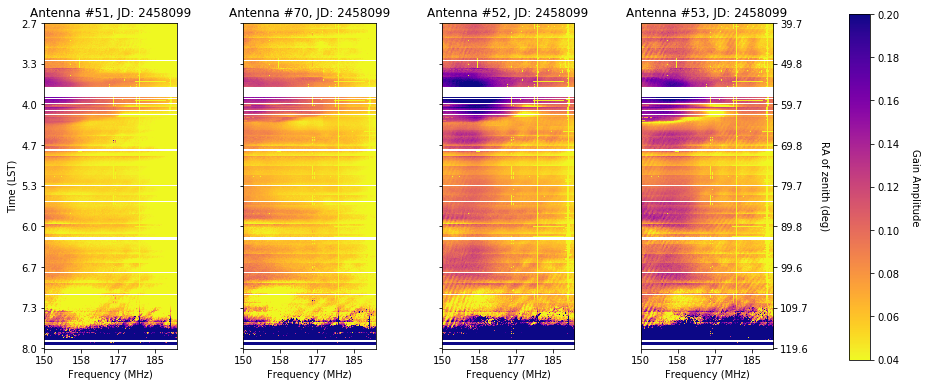

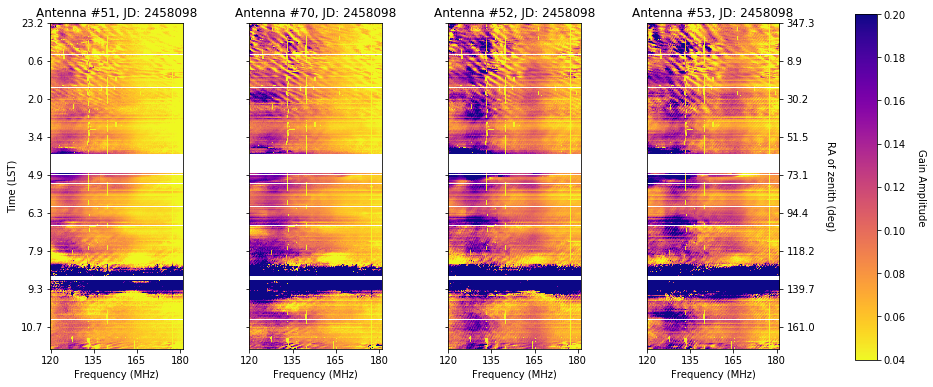

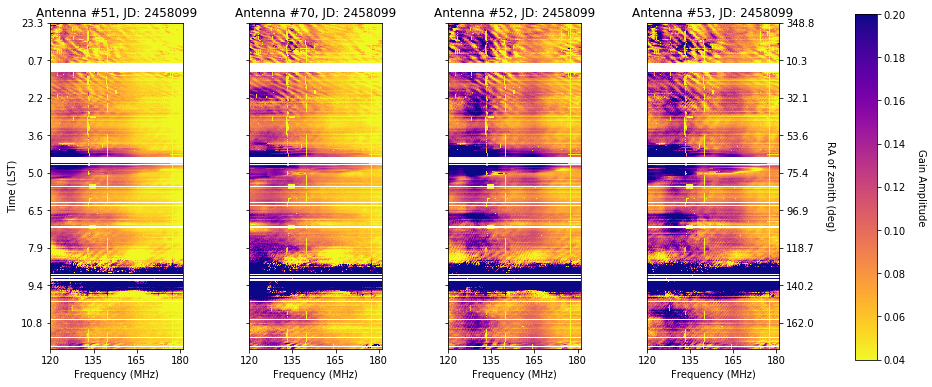

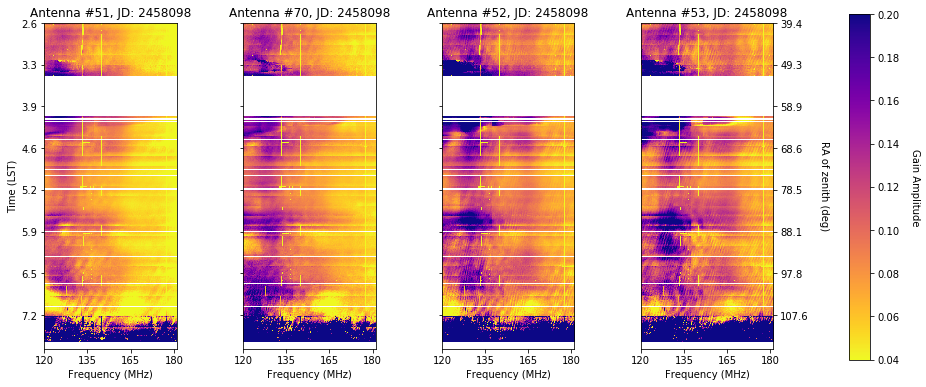

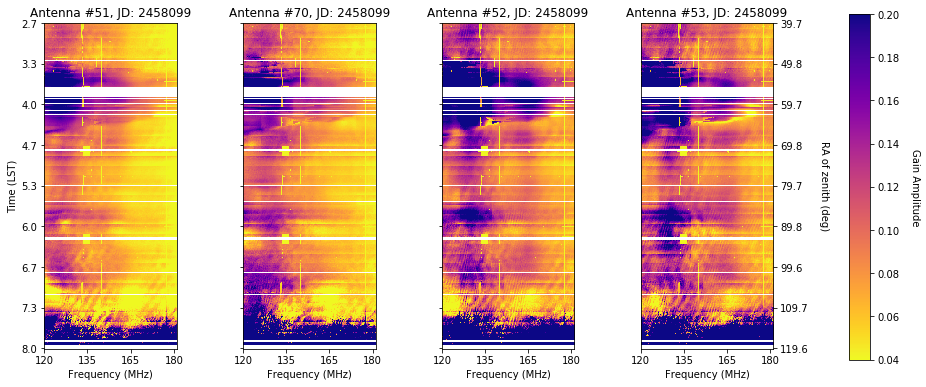

In [409]:
#plotWaterfalls(data_array,'withFileStartLines',firstFileLines=True,freq_range=[120,185],lst_range=[2,8])
#plotWaterfalls(data_array,'withoutFileStartLines',firstFileLines=False,freq_range=[120,185],lst_range=[2,8])
plotWaterfalls(data_array,firstFileLines=False,freq_range=[150,185],lst_range=[2,8],days=['2458099'])
#plotWaterfalls(data_array,firstFileLines=True,freq_range=[150,185],lst_range=[2,8],days=['2458099'])
plotWaterfalls(data_array,firstFileLines=False,freq_range=[120,180],lst_range='all')
plotWaterfalls(data_array,firstFileLines=False,freq_range=[120,180],lst_range=[2,8])

In [317]:
def plotMovieFrames_multiDay(data_array):
    for k in range(len(days)):
        fnames = str(days[k]) + '_' + frame_baseName
        fig, axs = plt.subplots(len(days),nants,figsize=(15,6))
        fig.subplots_adjust(hspace=0.5,wspace=0.5)
        fig.subplots_adjust(right=0.8)
        for t in range(len(vis)):
            for m in range(nants):
                ant = ant_nums[m]
                lbl = 'Antenna ' + str(ant)
                freq_array = data_array[days[k]][ant]['freq_array']
                axs[m].scatter(freq_array,data_array[days[k]][ant]['cal_array'][t,:],s=2,label=lbl)
            fname = fnames + '_' + str(t) + '.png'
            plt.title('Calibration Solutions for ' + days[k])
            plt.xlabel('Frequency (MHz)')
            plt.ylabel('Gain Amplitude')
            plt.ylim(0,0.3)
            plt.legend(loc='upper right')
            ax = plt.gca()
            currTime = data_array[days[k]][ant]['time_array'][t]
            timeStr = 'LST: ' + str(np.around(currTime,2))
            plt.text(0.03,0.9,timeStr,transform=ax.transAxes,fontsize=20)
            plt.savefig(fname)
            plt.show()
            plt.cla()

In [318]:
def plotMovieFrames(data_array):
    for k in range(len(days)):
        fnames = str(days[k]) + '_' + frame_baseName
        fig = plt.figure()
        for t in range(len(vis)):
            for m in range(nants):
                ant = ant_nums[m]
                lbl = 'Antenna ' + str(ant)
                freq_array = data_array[days[k]][ant]['freq_array']
                plt.scatter(freq_array,data_array[days[k]][ant]['cal_array'][t,:],s=2,label=lbl)
            fname = fnames + '_' + str(t) + '.png'
            plt.title('Calibration Solutions for ' + days[k])
            plt.xlabel('Frequency (MHz)')
            plt.ylabel('Gain Amplitude')
            plt.ylim(0,0.2)
            plt.legend(loc='upper right')
            ax = plt.gca()
            currTime = data_array[days[k]][ant]['time_array'][t]
            timeStr = 'LST: ' + str(np.around(currTime,2))
            plt.text(0.03,0.9,timeStr,transform=ax.transAxes,fontsize=20)
            plt.savefig(fname)
            plt.show()
            plt.cla()

In [319]:
def plotHorizontalCut(data_array,JD,lst):
    fig = plt.figure()
    for j in range(nants):
        #### Get index of this lst ####
        ant = ant_nums[j]
        lst_arr = data_array[JD][ant]["lst_array"]
        idx = (np.abs(lst_arr - np.asarray(lst))).argmin()
        cals = data_array[JD][ant]['cal_array'][idx,:]
        lbl = 'Antenna ' + str(ant_nums[j])
        freq_array = data_array[JD][ant]['freq_array']
        plt.scatter(freq_array,cals,s=2,label=lbl)
    plt.title('Calibration Solutions for ' + str(JD) + ' at LST ' + str(lst))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Gain Amplitude')
    plt.ylim(0,0.2)
    plt.legend(loc='upper right')
    ax = plt.gca()
    currTime = data_array[JD][ant]['lst_array'][idx]
    timeStr = 'LST: ' + str(np.around(currTime,2))
    plt.text(0.03,0.9,timeStr,transform=ax.transAxes,fontsize=20)

In [320]:
def plotVerticalCut(data_array,JD,freq):
    fig = plt.figure()
    for j in range(nants):
        ant = ant_nums[j]
        freq_arr = data_array[JD][ant]["freq_array"]
        idx = (np.abs(freq_arr - freq)).argmin()
        cal_array = data_array[JD][ant]['cal_array']
        lst_array = data_array[JD][ant]['lst_array']
        time_array = data_array[JD][ant]['time_array']
        cals = data_array[JD][ant]['cal_array'][:,idx]
        lbl = 'Antenna ' + str(ant)
        plt.scatter(lst_array,cals,s=2,label=lbl)
    plt.title(str(days[k]) + ' at ' + str(freq) + 'MHz')
    plt.xlabel('Time (LST)')
    plt.ylabel('Gain Amplitude')
    pltylim(0,0.2)
    plt.legend(loc='upper right')
    return fig

In [338]:
def plotVerticalCut_withAxes(data_array,JD,freq,ax,xlabel,ylabel,antennas=ant_nums,lst_range=[2,8]):
    #fig = plt.figure(figsize=(6,8))
    fig = plt.figure()
    nants = len(antennas)
    for j in range(nants):
        ant = antennas[j]
        #### Get index of this lst ####
        freq_array = data_array[JD][ant]["freq_array"]
        idx = (np.abs(freq_array - freq)).argmin()
        lst_array = data_array[JD][ant]['lst_array']
        #cals = data_array[JD][j]['cal_array'][:,idx]
        mx = data_array[JD][ant]['masked_data']
        mx, lst_array = getClippedTime(lst_array,mx,lst_range)
        mx = mx[:,idx]
        lbl = 'Antenna ' + str(ant)
        #ax.scatter(lst_array,mx,s=2,label=lbl)
        ax.plot(lst_array,mx,label=lbl)
    ax.set_title(str(days[k]) + ' at ' + str(freq) + 'MHz')
    if xlabel == True:
        ax.set_xlabel('Time (LST)')
    if ylabel == True:
        ax.set_ylabel('Gain Amplitude')
    ax.set_ylim(0,0.2)
    ax.legend(loc='upper right')
    return fig

In [359]:
def plotHorizontalCut_withAxes(data_array,JD,lst,ax,xlabel,ylabel,antennas=ant_nums,freq_range=[120,180]):
    fig = plt.figure()
    print(lst)
    nants = len(antennas)
    for j in range(nants):
        #### Get index of this lst ####
        ant = antennas[j]
        lst_arr = data_array[JD][ant]["lst_array"]
        idx = (np.abs(lst_arr - np.asarray(lst))).argmin()
        freq_array = data_array[JD][ant]['freq_array']
        #cals = data_array[JD][ant]['cal_array'][idx,:]
        mx = data_array[JD][ant]['masked_data']
        mx, freq_array = getClippedFrequency(freq_array,mx,freq_range)
        mx = mx[idx,:]
        lbl = 'Antenna ' + str(ant)
        ax.plot(freq_array,mx,label=lbl)
    ax.set_title('Calibration Solutions for ' + str(JD) + ' at LST ' + str(lst))
    ax.set_xlabel('Freq (MHz)')
    ax.set_ylabel('Gain Amplitude')
    ax.set_ylim(0,0.2)
    ax.legend(loc='upper right')
    currTime = data_array[JD][ant]['lst_array'][idx]
    timeStr = 'LST: ' + str(np.around(currTime,2))
    #plt.text(0.03,0.9,timeStr,transform=ax.transAxes,fontsize=20)

2458099
2
3.1
4
5.1
6
7.1
2
3.1
4
5.1
6
7.1


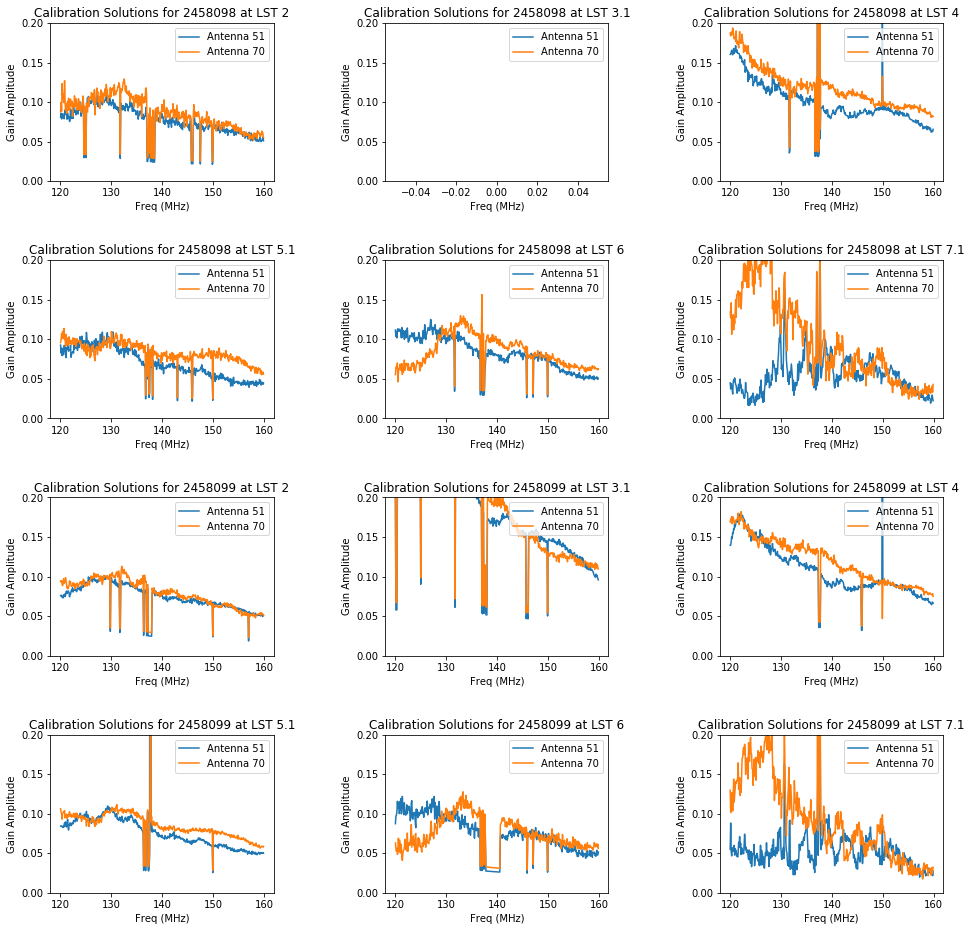

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [402]:
outdir = '/lustre/aoc/projects/hera/dstorer/Projects/plotScripts/movieFrames/horizontalCutGrids'
lsts = [[2,3.1,4],[5.1,6,7.1]]
fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(16,16))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
antennas = [51,70]
n = 0
freqs = [120,160]
print(days[k])
for k in range(len(days)):
    for i in range(len(lsts)):
        for j in range(len(lsts[0])):        
            lst = lsts[i][j]
            xlabel = False
            ylabel = False
            if k == len(days)-1 and i == len(freqs)-1:
                xlabel = True
            if j == 0:
                ylabel = True
            plotHorizontalCut_withAxes(data_array,days[k],lst,axes[n][j],xlabel,ylabel,antennas=antennas,freq_range=freqs)
        n = n + 1

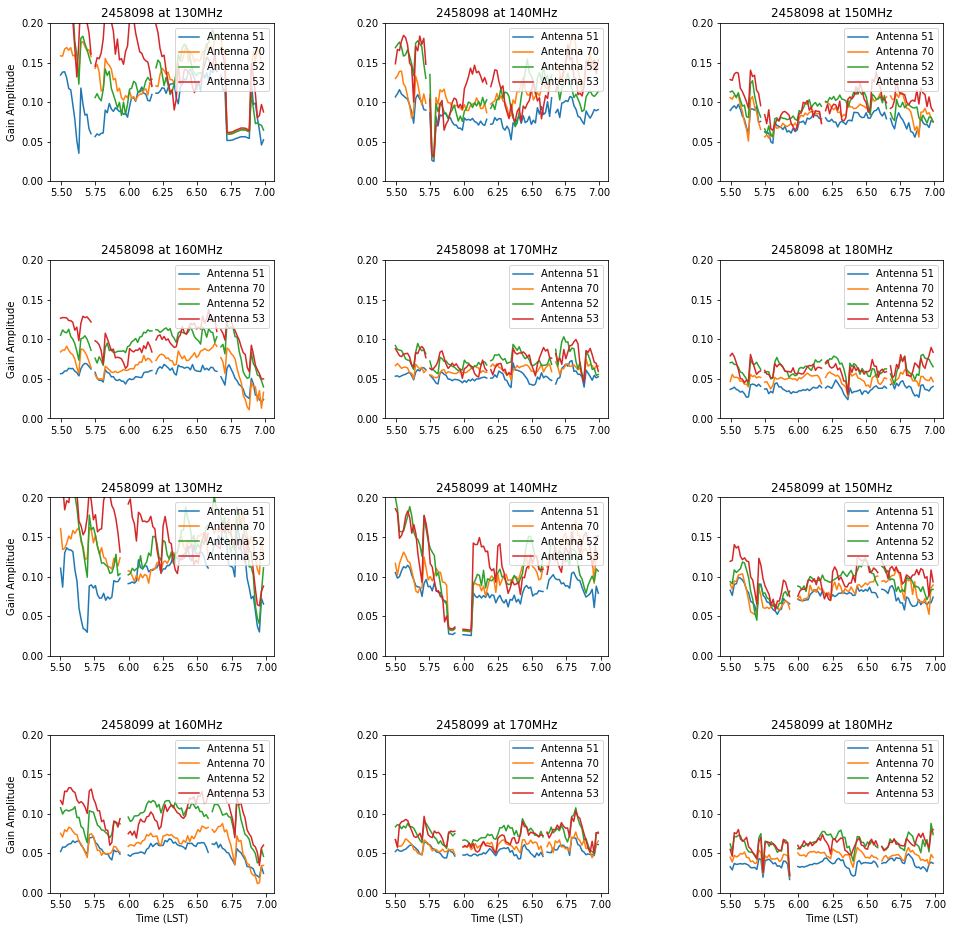

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [368]:
outdir = '/lustre/aoc/projects/hera/dstorer/Projects/plotScripts/movieFrames/verticalCutGrids'
freqs = [[130,140,150],[160,170,180]]
fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(16,16))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
antennas = [51,70,52,53]
n = 0
times = [2,8]
times = [5.5,7]
for k in range(len(days)):
    for i in range(len(freqs)):
        for j in range(len(freqs[0])):        
            freq = freqs[i][j]
            xlabel = False
            ylabel = False
            if k == len(days)-1 and i == len(freqs)-1:
                xlabel = True
            if j == 0:
                ylabel = True
            plotVerticalCut_withAxes(data_array,days[k],freq,axes[n][j],xlabel,ylabel,antennas=antennas,lst_range=times)
        n = n + 1

In [291]:
freqs = []
lsts = []
for f in freqs:
    fig, axs = plt.subplots(1, len(lsts))
    fig.subplots_adjust(hspace=0.5,wspace=0.5)
    fig.subplots_adjust(right=0.8)
    for t in range(len(lst)):
        lst = lsts[t]
        fig = 

SyntaxError: invalid syntax (<ipython-input-291-0129257b717e>, line 9)

(421, 666)
(421,)
(421,)
(421, 666)
(421,)
(421,)


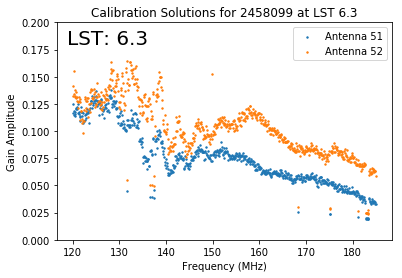

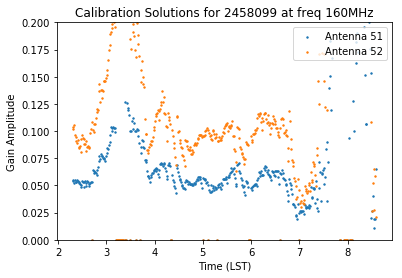

In [169]:
plotHorizontalCut(data_array,'2458099',6.3)
plotVerticalCut(data_array,'2458099',160)

In [224]:
k = 0
j = 0
freq_range = [120,180]
lst_range = [2,8]
mx = data_array[days[k]][j]["masked_data"]
freq_array = data_array[days[k]][j]["freq_array"]
time_array = data_array[days[k]][j]["lst_array"]
jd_array = data_array[days[k]][j]["time_array"]
zens = data_array[days[k]][j]["zenith_RA_array"]
idx0 = (np.abs(freq_array - freq_range[0])).argmin()
idx1 = (np.abs(freq_array - freq_range[1])).argmin()
freq_array = freq_array[idx0:idx1]
mx = mx[:,idx0:idx1]
idx0 = (np.abs(time_array - np.asarray(lst_range[0]))).argmin()
idx1 = (np.abs(time_array - np.asarray(lst_range[1]))).argmin()
time_array = time_array[idx0:idx1]
mx = mx[idx0:idx1,:]


print(np.shape(mx))
print(np.shape(freq_array))
print(np.shape(time_array))
print(np.shape(jd_array))

(391, 614)
(614,)
(391,)
(859,)
